In [1]:
import pandas as pd
import numpy as np
from scipy import stats
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 그래프에서 마이너스 폰트 깨짐 대처
mpl.rcParams['axes.unicode_minus'] = False

# treat time
from datetime import datetime
import calendar

train = pd.read_csv('train.csv')
train['date'] = train['datetime'].apply(lambda x: x.split()[0])
train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
train['weekDay'] = train['date'].apply(lambda dateString: calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])
train['month'] = train['date'].apply(lambda x: calendar.month_name[datetime.strptime(x,'%Y-%m-%d').month])
train['season'] = train['season'].map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
train['weather'] = train['weather'].map({
    1:'Clear + Few clouds + Partly cloudy + Partly cloudy',
    2:'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
    3:' Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
    4:'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
})
categoryVariableList = ['hour','weekDay','month','season','weather','holiday','workingday']

for var in categoryVariableList:
    train[var] = train[var].astype('category')
train = train.drop(['datetime'], axis=1)

trainWithoutOutliers = train[np.abs(train['count'] - train['count'].mean()) <= (3*train['count'].std())]

## 1. Filling 0's In windspeed Using Random Forest

### Read In Train Set and Test Set

In [2]:
dataTrain = pd.read_csv('train.csv')
dataTest = pd.read_csv('test.csv')
print(dataTrain.shape)
print(dataTest.shape)

(10886, 12)
(6493, 9)


### Combine Train and Test

In [3]:
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)
data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


### Feature Engineering

In [4]:
data['date'] = data['datetime'].apply(lambda x: x.split()[0])
data['hour'] = data['datetime'].apply(lambda x: x.split()[1].split(':')[0]).astype('int')
data['year'] = data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
data['weekday'] = data['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').weekday())
data['month'] = data['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').month)

### Random Forest Model To Predict 0's In Windspeed

In [5]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data['windspeed'] == 0]
dataWindNot0 = data[data['windspeed'] != 0]

rf_wind = RandomForestRegressor()

# 풍속에 영향을 주는 column들만 모아둔 리스트
windColumns = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']

# windwpeed가 0이 아닌 데이터셋을 이용해 랜덤 포레스트 모델 학습
rf_wind.fit(dataWindNot0[windColumns], dataWindNot0['windspeed'])

# windspeed가 0인 데이터 포인트의 windspeed 예측
wind0Values = rf_wind.predict(X = dataWind0[windColumns])

dataWind0['windspeed'] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

### Coercing To Categorical Type

In [6]:
data.columns

Index(['atemp', 'casual', 'count', 'datetime', 'holiday', 'humidity',
       'registered', 'season', 'temp', 'weather', 'windspeed', 'workingday',
       'date', 'hour', 'year', 'weekday', 'month'],
      dtype='object')

In [7]:
categoricalFeatureNames = ['season', 'holiday', 'weather', 'workingday','weekday', 'month', 'year','hour']
numericalFeatureNames = ['atemp','humidity','temp','windspeed']
dropFeatures = ['casual','datetime','registered','count','date']

In [8]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype('category')

### Splitting Train and Test Set  
  
전처리를 마친 data를 다시 Train Set과 Test Set으로 나눠준다.

In [9]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by='datetime')
dataTest = data[pd.isnull(data['count'])].sort_values(by='datetime')
datetimecol = dataTest['datetime']
yLabels = dataTrain['count']
yLabelsRegistered = dataTrain['registered']
yLabelsCasual = dataTrain['casual']

### Dropping Unnecessary Variables

In [10]:
dataTrain = dataTrain.drop(dropFeatures, axis=1)
dataTest = dataTest.drop(dropFeatures, axis=1)

### RMSLE Scorer  
이번 대회의 점수 산정 방식의 함수를 만든다.

In [11]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 예측값과 실제값에 1을 더하고 로그를 씌워준다.
    log1 = np.nan_to_num(np.array([np.log(x + 1) for x in y_true]))
    log2 = np.nan_to_num(np.array([np.log(x + 1) for x in y_pred]))
    
    # 위에서 계산한 예측값에서 실제값을 빼고 제곱을 해준다.
    cal = (log1 - log2) ** 2
    
    # 평균의 제곱을 반환한다.
    return np.sqrt(np.mean(cal))

## Linear Regression Model  
  
선형 회귀 모델은 가정 중 종속변수의 정규성이 있기 때문에 y에 로그를 취해준 값에 대하여 모델을 적합하고 예측한 뒤, 예측값에 다시 지수 변환을 해준다.

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Initialize regression model
lr = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels) 
lr.fit(X=dataTrain, y=yLabelsLog)

# Make predictions
preds = lr.predict(X=dataTrain)
print('RMSLE Value For Linear Regression on Train set: {}'.format(rmsle(np.exp(yLabelsLog), np.exp(preds), False)))

RMSLE Value For Linear Regression on Train set: 0.977966105984815


## Regularization Model - Ridge

In [13]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit( dataTrain, yLabelsLog )
preds = grid_ridge_m.predict(X= dataTrain)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))



{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9779660909098081


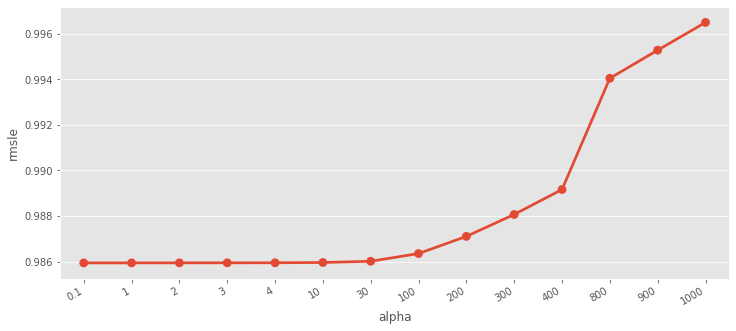

In [14]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["param_alpha"]
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)